### This investigation is based on a dataset found on Kaggle: https://www.kaggle.com/lumins/settlers-of-catan-games 
### It contains information for 50 four-player games of Settlers of Catan. Descriptions of the information contained in the dataset can be found at the website given above. There is not exactly a purpose of this notebook other than to explore some of the data for fun, and attempt to make a model that will predict the winner of the game. 

In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV, Ridge, LinearRegression, LogisticRegression


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Lasso

In [297]:
df = pd.read_csv('catanstats.csv')

In [300]:
df.head()

,gameNum,player,points,me,2,3,4,5,6,7,...,Unnamed: 26,production,tradeGain,robberCardsGain,totalGain,tradeLoss,robberCardsLoss,tribute,totalLoss,totalAvailable
0,1,1,5,NaN,1,3,5,8,7,10,...,O,38,5,2,45,10,2,4,16,29
1,1,2,9,1.0,1,3,5,8,7,10,...,O,48,8,6,62,11,1,8,20,42
2,1,3,10,NaN,1,3,5,8,7,10,...,C,44,14,9,67,24,4,0,28,39
3,1,4,5,NaN,1,3,5,8,7,10,...,S,42,12,0,54,24,6,0,30,24
4,2,1,10,NaN,1,6,3,9,10,8,...,2L,60,15,16,91,28,10,0,38,53


In [299]:
df.columns

Index(['gameNum', 'player', 'points', 'me', '2', '3', '4', '5', '6', '7', '8',
       '9', '10', '11', '12', 'settlement1', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'settlement2',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25',
       'Unnamed: 26', 'production', 'tradeGain', 'robberCardsGain',
       'totalGain', 'tradeLoss', 'robberCardsLoss', 'tribute', 'totalLoss',
       'totalAvailable'],
      dtype='object')

Renaming the columns

In [301]:
df = df.rename(columns={'settlement1':'set1_a_num', 'Unnamed: 16':'set1_a_rec', 'Unnamed: 17':'set1_b_num', 'Unnamed: 18':'set1_b_rec', 'Unnamed: 19':'set1_c_num', 'Unnamed: 20':'set1_c_rec', 
                        'settlement2':'set2_a_num', 'Unnamed: 22':'set2_a_rec', 'Unnamed: 23':'set2_b_num', 'Unnamed: 24':'set2_b_rec', 'Unnamed: 25':'set2_c_num', 'Unnamed: 26':'set2_c_rec', })


Relabeling the resource names as integers

In [302]:
#function to relable recources as numbers (assuming 'B' is a typo for 'D')

def relabel(column):
    for i in range(200):
        if df.loc[i,column] == 'L':
            df.loc[i,column] = 1
        elif df.loc[i,column] == 'C':
            df.loc[i,column] = 2
        elif df.loc[i,column] == 'S':
            df.loc[i,column] = 3
        elif df.loc[i,column] == 'W':
            df.loc[i,column] = 4
        elif df.loc[i,column] == 'O':
            df.loc[i,column] = 5
        elif df.loc[i,column] == '3G':
            df.loc[i,column] = 6
        elif df.loc[i,column] == '2L':
            df.loc[i,column] = 7
        elif df.loc[i,column] == '2C':
            df.loc[i,column] = 8
        elif df.loc[i,column] == '2S':
            df.loc[i,column] = 9
        elif df.loc[i,column] == '2W':
            df.loc[i,column] = 10
        elif df.loc[i,column] == '2O':
            df.loc[i,column] = 11
        elif df.loc[i,column] == 'D':
            df.loc[i,column] = 12
        elif df.loc[i,column] == 'B':
            df.loc[i,column] = 12
            

In [303]:
relabel('set1_a_rec')
relabel('set1_b_rec')
relabel('set1_c_rec')
relabel('set2_a_rec')
relabel('set2_b_rec')
relabel('set2_c_rec')

Create a Total Rolls column

In [304]:
df['TotalRolls'] = df.iloc[:,4:15].sum(axis = 1)

Create a binary Winner column

In [305]:
# Creating a 'Winner' column: 1 if the player won, -1 if lost
for i in range(200):
    if df.loc[i,'points'] >9:
        df.loc[i,'Winner'] = 1
    else:
        df.loc[i,'Winner'] = -1

Next we find a way to measure how "predictable" the rolls of each game were by creating some sort of metric for the "improbability" of the game. That is, we look at the probability of rolling a certain number, and multiply it by the total number of dice rolled. This gives us the value for how many times this number "should" have been rolled in that game. We then find the absolute value of the difference between this value and the actual number of times that number was rolled. Summing these values up (for each number 2 through 12), this gives us an "improbability" measure for the game. 

In [306]:
#Finding all possible combinations of two dice rolls

from itertools import product

combinations = list(product(range(1,7), repeat=2))
len(combinations)

36

In [307]:
#function to find the probability of rolling r (with two dice)
def prob(r):
    count = 0
    for i in range(36):
        if r == np.sum(combinations[i]):
            count += 1
    return (count / 36)

In [308]:
#measuring the improbability of the game
for i in range(200):
    measure = 0
    for j in range(11):
        measure += np.abs(df.iloc[i,j+4] - (prob(j+2) * df.loc[i, 'TotalRolls']))
    df.loc[i, 'Improbability'] = measure
        

We normalize the improbability number so that it is in between 0 and 1. A normed improbability of 0 means that the rolls were exactly how we would have predicted them to be based on their probabilities. A normed improbability of 1 means that, out of the data given, the rolls of that game were the least "predictable."

In [309]:
df['Improbability_norm']=(df.loc[:,'Improbability'])/(df.loc[:,'Improbability'].max())


It seems to make the most sense that there would be some sort of correlation between the production and the points. We examine this below.

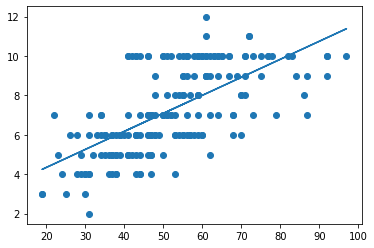

Mean squared error: 2.64
Coefficient of determination: 0.43


In [310]:


x = np.array(df.loc[:,'production'])
y = np.array(df.loc[:,'points'])

plt.scatter(x, y)

X, Y = x.reshape(-1,1), y.reshape(-1,1)
plt.plot( X, LinearRegression().fit(X, Y).predict(X) )
plt.show()

print('Mean squared error: %.2f'
      % mean_squared_error(Y, LinearRegression().fit(X, Y).predict(X)))
print('Coefficient of determination: %.2f'
      % r2_score(Y, LinearRegression().fit(X, Y).predict(X)))

In the data given, it doesn't seem like there are a very strong correlation. 

### Examining just the winners and losers

In [311]:
df_winner = pd.DataFrame(columns = df.columns)

for i in range(200):
    if df.loc[i, 'points'] > 9:
        df_winner.loc[i,:] = df.loc[i,:]

df_winner = df_winner.reset_index(drop = True)


df_losers = pd.DataFrame(columns = df.columns)

for i in range(200):
    if df.loc[i, 'points'] < 10:
        df_losers.loc[i,:] = df.loc[i,:]

df_losers = df_losers.reset_index(drop = True)


2    18
3    14
4    10
1     8
Name: player, dtype: int64
2    0.36
3    0.28
4    0.20
1    0.16
Name: player, dtype: float64


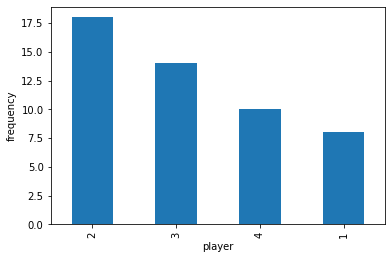

In [393]:
print(df_winner['player'].value_counts())
print(df_winner['player'].value_counts()/50)

df_winner['player'].value_counts().plot(kind = 'bar')
plt.xlabel('player')
plt.ylabel('frequency')
plt.show()

Player 2 won the most amount of times (36% of the time). This may be worth further investigation, since the order of the player determines the order of choosing the initial two settlements.

1    42
4    40
3    36
2    32
Name: player, dtype: int64
1    0.84
4    0.80
3    0.72
2    0.64
Name: player, dtype: float64


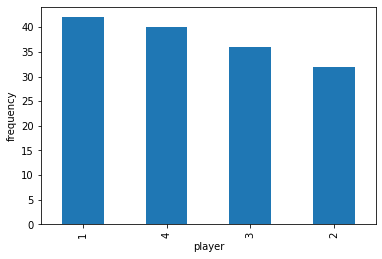

In [394]:
print(df_losers['player'].value_counts())
print(df_losers['player'].value_counts()/50)

df_losers['player'].value_counts().plot(kind = 'bar')
plt.xlabel('player')
plt.ylabel('frequency')
plt.show()

Player 1 lost the most (84% of the time). This is surprising, since player 1 gets to choose the first settlement, and so you would think that player 1 may have some sort of advantage. 

Below, we check to see if the "improbability" of the rolls in the game has any correlation on the amount of production. Intuitively, we guess that the more improbable the game, the lower the production. 

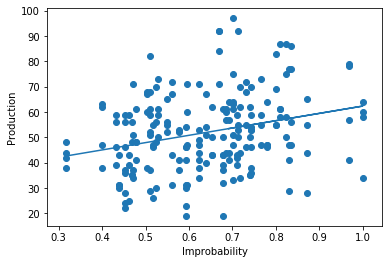

Mean squared error: 218.68
Coefficient of determination: 0.08


In [395]:
x2 = np.array(df.loc[:,'Improbability_norm'])
y2 = np.array(df.loc[:,'production'])

plt.scatter(x2, y2)

X2, Y2 = x2.reshape(-1,1), y2.reshape(-1,1)
plt.plot( X2, LinearRegression().fit(X2, Y2).predict(X2) )
plt.xlabel('Improbability')
plt.ylabel('Production')

plt.show()

print('Mean squared error: %.2f'
      % mean_squared_error(Y2, LinearRegression().fit(X2, Y2).predict(X2)))
print('Coefficient of determination: %.2f'
      % r2_score(Y2, LinearRegression().fit(X2, Y2).predict(X2)))

We see that there is very little correlation between the improbability of hte rolls and the production

### How did the dice roll?

Below, we graph (in blue) the predicted rolls of a specific game (based on the probability of the rolls and the total number of rolls) versus the actual rolls of that game (in red).

In [314]:
def graph_improbability(game_num):
    dict = {}
    for i in [2,3,4,5,6,7,8,9,10,11,12]:
        dict[i] = prob(i) *df_winner.loc[game_num - 1, 'TotalRolls']
        
    plt.bar(dict.keys(), dict.values(), alpha = 0.75)
    for j in range(11):
        plt.bar(j+2,df_winner.iloc[game_num -1 ,j+4], color = 'red', alpha = 0.25)
    plt.xlabel('Dice Roll')
    plt.ylabel('Frequency')
    plt.title('Predicted Rolls (in Blue) vs. Actual Game Rolls (in Red) for Game %i' %game_num)
    plt.show()
    print('Normalized Improbability Score for Game %i:'%game_num, df_winner.loc[game_num - 1, 'Improbability_norm'])

Below, we graph the game with the highest improbability score (game 24) and the lowest improbability score (game 1)

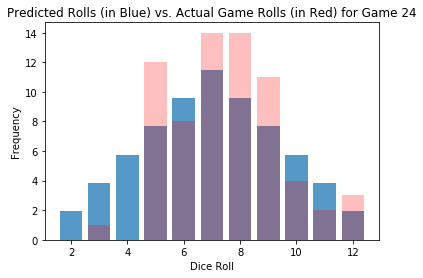

Normalized Improbability Score for Game 24: 1.0





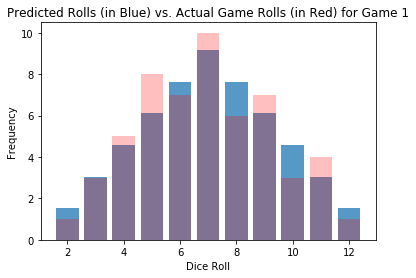

Normalized Improbability Score for Game 1: 0.31737588652482274


In [316]:
graph_improbability(game_num = 24)
print()
print()
print()
graph_improbability(game_num = 1)

Here is the graph of the total rolls added up over all the games. As we would assume, the actual rolls (red) approaches the expected rolls (blue) the more rolls we make.

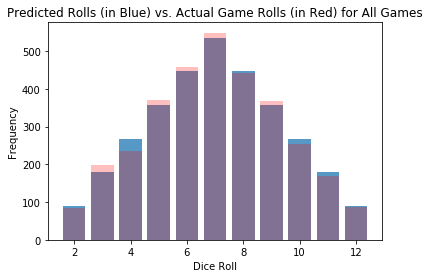

In [24]:
dict = {}
for i in [2,3,4,5,6,7,8,9,10,11,12]:
    dict[i] = prob(i) * sum(df_winner.loc[:, 'TotalRolls'])
        
plt.bar(dict.keys(), dict.values(), alpha = 0.75)
for j in range(11):
    plt.bar(j+2,sum(df_winner.iloc[:,j+4]), color = 'red', alpha = 0.25)
plt.xlabel('Dice Roll')
plt.ylabel('Frequency')
plt.title('Predicted Rolls (in Blue) vs. Actual Game Rolls (in Red) for All Games')
plt.show()

### Trying to predict the winner of the game

In [28]:
df.columns

Index(['gameNum', 'player', 'points', 'me', '2', '3', '4', '5', '6', '7', '8',
       '9', '10', '11', '12', 'set1_a_num', 'set1_a_rec', 'set1_b_num',
       'set1_b_rec', 'set1_c_num', 'set1_c_rec', 'set2_a_num', 'set2_a_rec',
       'set2_b_num', 'set2_b_rec', 'set2_c_num', 'set2_c_rec', 'production',
       'tradeGain', 'robberCardsGain', 'totalGain', 'tradeLoss',
       'robberCardsLoss', 'tribute', 'totalLoss', 'totalAvailable',
       'TotalRolls', 'Winner', 'Improbability', 'Improbability_norm'],
      dtype='object')

Fitting a model to predict the winner

In [397]:
X = np.array(df.loc[:,['player', 'set1_a_num', 'set1_a_rec', 'set1_b_num',
       'set1_b_rec', 'set1_c_num', 'set1_c_rec', 'set2_a_num', 'set2_a_rec',
       'set2_b_num', 'set2_b_rec', 'set2_c_num', 'set2_c_rec', 'production',
       'tradeGain', 'robberCardsGain', 'tradeLoss',
       'robberCardsLoss', 'tribute']])
           
y = np.array(df.loc[:, ['Winner']])

In [398]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [399]:
def prediction(pred):
    for i in range(len(pred)):
            if pred[i] > 0:
                pred[i] = 1
            else:
                pred[i] = -1

Using Linear Regression

In [400]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

prediction(y_pred)
        
print('Accuracy:', accuracy_score(y_test,y_pred))


Accuracy: 0.74


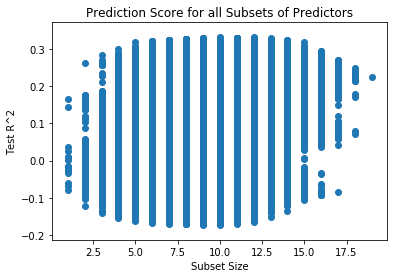

In [73]:
from itertools import combinations
plot_values = []
for i in range(1,20):
    combi = list(combinations(range(19),i))
    for c in combi:
        c = list(c)
        lin_reg=LinearRegression()
        lin_reg.fit(X_train[:,c], y_train)
        plot_values.append([len(c), lin_reg.score(X_test[:,c],y_test)])
plot_values = pd.DataFrame(plot_values)
plt.scatter(plot_values.iloc[:,0], plot_values.iloc[:,1])
plt.xlabel('Subset Size')
plt.ylabel('Test R^2')
plt.title('Prediction Score for all Subsets of Predictors')
plt.show()

Even using subset selection, we don't get a particularly high R^2 value

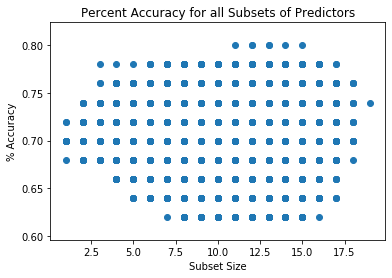

In [246]:
plot_values = []
for i in range(1,20):
    combi = list(combinations(range(19),i))
    for c in combi:
        c = list(c)
        lin_reg=LinearRegression()
        lin_reg.fit(X_train[:,c], y_train)
        y_pred = lin_reg.predict(X_test[:,c])

        prediction(y_pred)
        
        plot_values.append([len(c), accuracy_score(y_test,y_pred)])
plot_values = pd.DataFrame(plot_values)
plt.scatter(plot_values.iloc[:,0], plot_values.iloc[:,1])
plt.xlabel('Subset Size')
plt.ylabel('% Accuracy')
plt.title('Percent Accuracy for all Subsets of Predictors')
plt.show()

Using subset selection, we do see that some subsets of our predictors give us up to 80% accuracy

Next, we use Lasso regression.

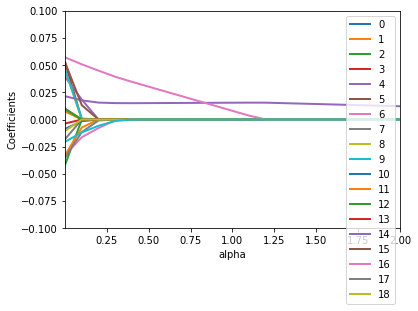

In [321]:
y_train=y_train.reshape(150)
p=19


alphas = np.arange(0.001,5,0.1) # 0.1 to 2, step = 0.1 
N = len(alphas) # Number of lasso parameters
betas = np.zeros((N,p+1)) # p+1 because of intercept
for i in range(N):
    clf = Lasso(alphas[i], fit_intercept= True) 
    clf.fit(X_train,y_train)
    betas[i,0] = clf.intercept_ 
    betas[i,1:] = clf.coef_
plt.plot(alphas,betas,linewidth=2) 
plt.legend(range(p)) 
plt.xlabel('alpha') 
plt.ylabel('Coefficients') 
plt.xlim(min(alphas),2) 
plt.ylim(-0.1, 0.1)
plt.show()

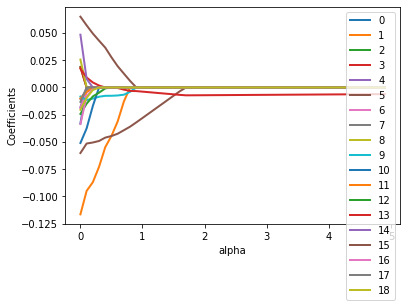

In [322]:
y_train=y_train.reshape(150)
p=19


alphas = np.arange(0.001,5,0.1) # 0.1 to 2, step = 0.1 
N = len(alphas) # Number of lasso parameters
betas = np.zeros((N,p)) # p+1 because of intercept
for i in range(N):
    clf = Lasso(alphas[i], fit_intercept= False) 
    clf.fit(X_train,y_train)
    #betas[i,0] = clf.intercept_ 
    betas[i,:] = clf.coef_
plt.plot(alphas,betas,linewidth=2) 
plt.legend(range(p)) 
plt.xlabel('alpha') 
plt.ylabel('Coefficients') 


plt.show()

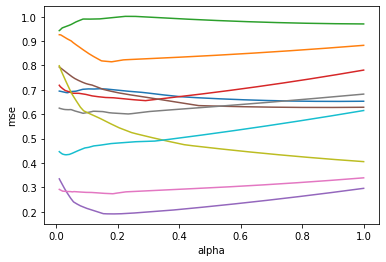

In [401]:
y_train=y_train.reshape(150)
alphas = np.exp(np.linspace(np.log(0.01),np.log(1),1000))
lasso=LassoCV(alphas=alphas, cv = 10)
lasso.fit(X_train,y_train)
plt.plot(lasso.alphas_, lasso.mse_path_)
plt.xlabel('alpha')
plt.ylabel('mse')
plt.show()

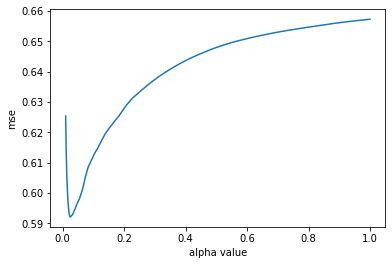

0.5920728764732345
best alpha value: 0.02456916462982792


In [323]:
y_train=y_train.reshape(150)

K=10
alphas = np.exp(np.linspace(np.log(0.01),np.log(1),1000))
num_alphas = len(alphas)

scores = np.zeros((num_alphas,1))

clf=LassoCV(alphas = alphas, cv = K)
clf.fit(X_train, y_train)    

scores_avg = clf.mse_path_.mean(axis = 1)

plt.plot(clf.alphas, scores_avg)
plt.xlabel('alpha value')
plt.ylabel('mse')
plt.show()

print(np.min(scores_avg))
print('best alpha value:', alphas[np.argmin(scores_avg)])

In [324]:
lasso = Lasso(alpha = 0.02456916462982792)
lasso.fit(X_train, y_train)

print(lasso.coef_)

y_pred = lasso.predict(X_test)
prediction(y_pred)

print('accuracy:', accuracy_score(y_test,y_pred))

[ 0.         -0.00980563  0.0348119   0.03311417  0.         -0.02411682
 -0.00850369  0.02344779  0.03253843 -0.00873696 -0.02797342  0.00174537
 -0.00607294  0.02083933  0.04054524  0.05562981 -0.02829806 -0.00806776
 -0.01829772]
accuracy: 0.7


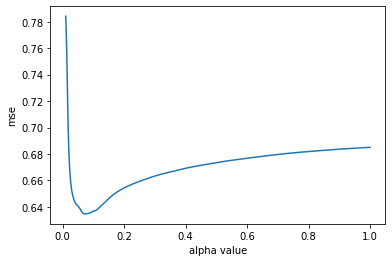

0.634702509529408
best alpha value: 0.07159041085964889


In [325]:
y_train=y_train.reshape(150)

K=10
alphas = np.exp(np.linspace(np.log(0.01),np.log(1),1000))
num_alphas = len(alphas)

scores = np.zeros((num_alphas,1))

clf=LassoCV(alphas = alphas, cv = K, fit_intercept = False)
clf.fit(X_train, y_train)    

scores_avg = clf.mse_path_.mean(axis = 1)

plt.plot(clf.alphas, scores_avg)
plt.xlabel('alpha value')
plt.ylabel('mse')
plt.show()


print(np.min(scores_avg))
print('best alpha value:', alphas[np.argmin(scores_avg)])

In [326]:
lasso = Lasso(alpha = 0.07159041085964889, fit_intercept = False)
lasso.fit(X_train, y_train)

print(lasso.coef_)

y_pred = lasso.predict(X_test)
prediction(y_pred)

print('accuracy:', accuracy_score(y_test,y_pred))

[-0.         -0.09854506  0.          0.         -0.         -0.05238213
 -0.00832704 -0.00359476  0.         -0.01158267 -0.04382334 -0.00548588
 -0.01625417  0.0109052   0.02161624  0.0595143  -0.01555305 -0.
 -0.01252943]
accuracy: 0.68


So lasso regression only gives us about 70% accuracy. It might be worth exploring what predictors the lasso regression found more or less important, and if those agreed with some of the subsets that gave 80% accuracy using linear regression.

Next, we use the nearest neighbors classifier.

In [327]:
from sklearn.neighbors import KNeighborsClassifier

mean_scores = []
for k in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring="accuracy")
    mean_scores.append(scores.mean())

print('best mean score = ', max(mean_scores))
print('neighbors =',  np.argmax(mean_scores)+1)

best mean score =  0.7866666666666667
neighbors = 21


In [329]:
from sklearn.metrics import classification_report
knn21 = KNeighborsClassifier(n_neighbors=21)
knn21.fit(X_train,y_train)
y_pred = knn21.predict(X_test)
print(knn21.score(X_test, y_test))


0.72


78% accuracy on the training set and 72% accuracy on the test set isn't terrible, but it's also not great.

Using Logistic Regression

In [330]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
log_reg = GridSearchCV(LogisticRegression(max_iter = 1000), param_grid)

log_reg = log_reg.fit(X_train, y_train)

print(log_reg.best_params_)
print(log_reg.best_score_)

{'C': 0.01}
0.7733333333333334


In [331]:
log_reg = LogisticRegression(C = .01, max_iter = 1000)
log_reg.fit(X_train,y_train)
print(log_reg.score(X_test,y_test))
y_pred = log_reg.predict(X_test)

0.72


Let's take a deeper look into our nearest neighbors model

In [332]:
knn21 = KNeighborsClassifier(n_neighbors=21)
knn21.fit(X_train,y_train)
y_pred = knn21.predict(X_test)
print(y_pred)

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


Hmmm that's a lot of "lose" predictions and not a lot of "win" predictions. Let's look at this a little closer.

[[37  1]
 [12  0]]


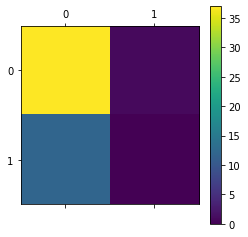

In [384]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, y_pred)
print(confusion)

def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
plot_confusion_matrix(confusion)

Our suspicion was correct. The model is great at getting the "lost" games correct, because it predicted all but one as a loss. There were 13 "win" games that it incorrectly predicted as lost. Could this possibly be because the proportion of losses to wins was much higher in the training set than the test set? In reality, since every game has three players lose and one player win, the ratio of losses to wins should be 3:1. If there were 15 wins in the test set, then the ration of losses to wins in the test set is 35:15, which is 2.333:1. So, in fact, the ratio of losses to wins in the training set would be higher than 3:1. This could account for our model overpredicting losses. Let's try to find a train/test split that has a ratio closes to the true 3:1 ratio.

In [385]:
X = np.array(df.loc[:,['player', 'set1_a_num', 'set1_a_rec', 'set1_b_num',
       'set1_b_rec', 'set1_c_num', 'set1_c_rec', 'set2_a_num', 'set2_a_rec',
       'set2_b_num', 'set2_b_rec', 'set2_c_num', 'set2_c_rec', 'production',
       'tradeGain', 'robberCardsGain', 'tradeLoss',
       'robberCardsLoss', 'tribute']])
           
y = np.array(df.loc[:, ['Winner']])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [386]:
count = 0
for i in range(50):
    if y_test[i] == 1:
        count += 1
print(count)

12


So the ratio of losses:wins in y_pred is 38:12, which is 3.1666:1. Then our training set has a higher proportion of wins. 

In [388]:
y_train=y_train.reshape(150)

mean_scores = []
for k in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring="accuracy")
    mean_scores.append(scores.mean())

print('best mean score = ', max(mean_scores))
print('neighbors =',  np.argmax(mean_scores)+1)

best mean score =  0.7666666666666667
neighbors = 24


In [389]:
knn21 = KNeighborsClassifier(n_neighbors=24)
knn21.fit(X_train,y_train)
y_pred = knn21.predict(X_test)
print(knn21.score(X_test, y_test))

0.74


In [390]:
y_pred

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.])

[[36  2]
 [11  1]]


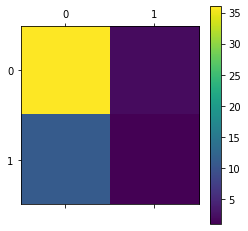

In [391]:
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

    
plot_confusion_matrix(confusion)

Well...we tried. It doesn't seem like the ratio of losses:wins in the training set affected the accuracy too much. This time, our model predicted 3 wins (instead of one), but only one of those predictions was actually correct. It seems as though the model just has a hard time predicting wins.